# Model Playground

Interactive exploration of the trained MiniCPM embedding model.
Compare base vs fine-tuned embeddings, visualise similarity structure, and sanity-check on custom inputs.

In [1]:
import sys, os
sys.path.insert(0, os.path.join(os.getcwd(), "mteb"))

from model.minicpm import MiniCPM
import numpy as np
import torch

MODEL_PATH = "../pretrained/MiniCPM-2B-dpo-bf16"
ADAPTER_PATH = "../train/output/20260221004650"  # latest training run

# Load both base and fine-tuned models
print("Loading base model...")
base_model = MiniCPM(model_path=MODEL_PATH)
print("Loading fine-tuned model...")
ft_model = MiniCPM(model_path=MODEL_PATH, adapter_path=ADAPTER_PATH)
print("Done.")

/home/ubuntu/Language-Model-STS-CFT/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading base model...
Loading fine-tuned model...
Done.


## 1. Cosine similarity: base vs fine-tuned

Compare how the two models score sentence pairs of varying similarity.

In [2]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

pairs = [
    # High similarity
    ("A cat is sitting on the mat.", "A kitten sits on a rug."),
    ("The stock market crashed today.", "Shares plummeted in today's trading."),
    # Medium similarity
    ("A cat is sitting on the mat.", "A dog is lying on the floor."),
    ("The weather is nice today.", "It's sunny outside."),
    # Low similarity
    ("A cat is sitting on the mat.", "The stock market crashed today."),
    ("I love programming in Python.", "The recipe calls for two eggs."),
]

rows = []
for s1, s2 in pairs:
    base_embs = base_model.encode([s1, s2])
    ft_embs = ft_model.encode([s1, s2])
    base_sim = cosine_similarity([base_embs[0]], [base_embs[1]])[0, 0]
    ft_sim = cosine_similarity([ft_embs[0]], [ft_embs[1]])[0, 0]
    rows.append({
        "sent1": s1[:50],
        "sent2": s2[:50],
        "base_cos": f"{base_sim:.4f}",
        "ft_cos": f"{ft_sim:.4f}",
        "delta": f"{ft_sim - base_sim:+.4f}",
    })

pd.DataFrame(rows)

,sent1,sent2,base_cos,ft_cos,delta
0,A cat is sitting on the mat.,A kitten sits on a rug.,0.9554,0.7745,-0.1809
1,The stock market crashed today.,Shares plummeted in today's trading.,0.8845,0.7840,-0.1005
2,A cat is sitting on the mat.,A dog is lying on the floor.,0.9726,0.5949,-0.3776
3,The weather is nice today.,It's sunny outside.,0.8987,0.7971,-0.1016
4,A cat is sitting on the mat.,The stock market crashed today.,0.7176,0.1169,-0.6007
5,I love programming in Python.,The recipe calls for two eggs.,0.8123,0.2890,-0.5233


## 2. Similarity heatmaps

Visualise the full pairwise similarity matrix for a set of sentences.

/tmp/ipykernel_4413/3480766012.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


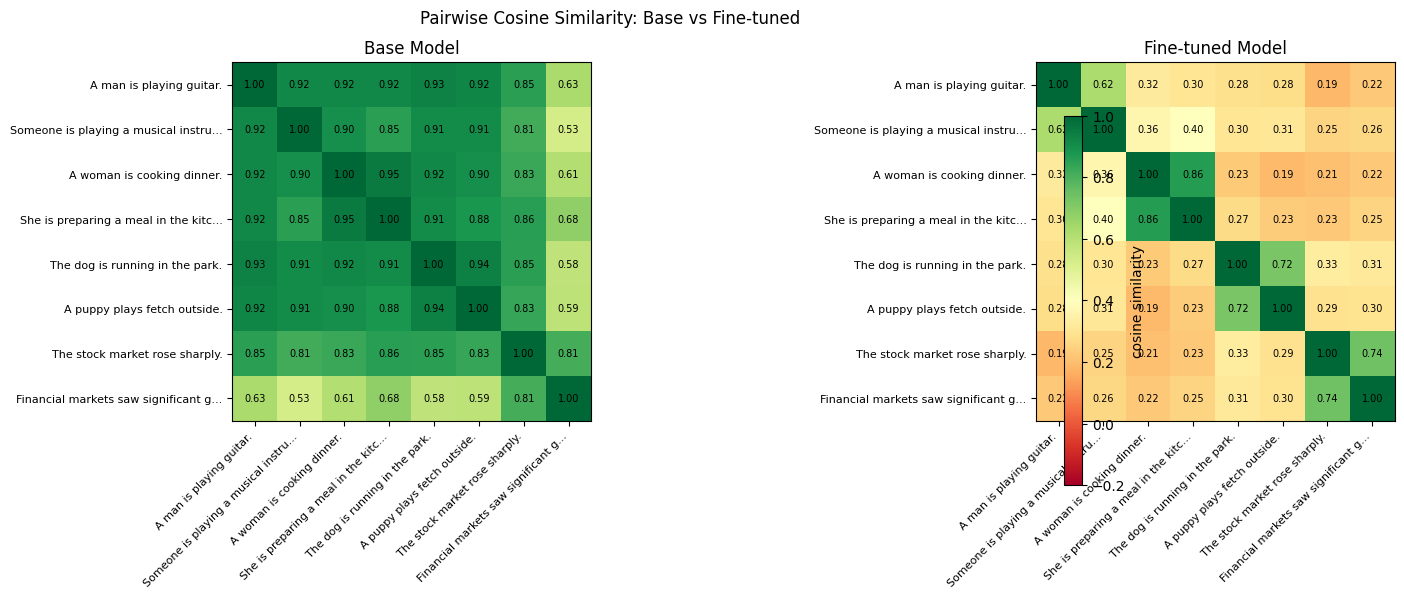

In [3]:
import matplotlib.pyplot as plt

sentences = [
    "A man is playing guitar.",
    "Someone is playing a musical instrument.",
    "A woman is cooking dinner.",
    "She is preparing a meal in the kitchen.",
    "The dog is running in the park.",
    "A puppy plays fetch outside.",
    "The stock market rose sharply.",
    "Financial markets saw significant gains.",
]

labels = [s[:35] + "..." if len(s) > 35 else s for s in sentences]

base_embs = np.array(base_model.encode(sentences))
ft_embs = np.array(ft_model.encode(sentences))

base_sim_mat = cosine_similarity(base_embs)
ft_sim_mat = cosine_similarity(ft_embs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

for ax, mat, title in [(ax1, base_sim_mat, "Base Model"), (ax2, ft_sim_mat, "Fine-tuned Model")]:
    im = ax.imshow(mat, cmap="RdYlGn", vmin=-0.2, vmax=1.0)
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right", fontsize=8)
    ax.set_yticklabels(labels, fontsize=8)
    ax.set_title(title)
    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(j, i, f"{mat[i,j]:.2f}", ha="center", va="center", fontsize=7)

fig.colorbar(im, ax=[ax1, ax2], shrink=0.8, label="cosine similarity")
plt.suptitle("Pairwise Cosine Similarity: Base vs Fine-tuned")
plt.tight_layout()
plt.show()

## 3. t-SNE visualisation

Project embeddings to 2D to see if semantically similar sentences cluster together.

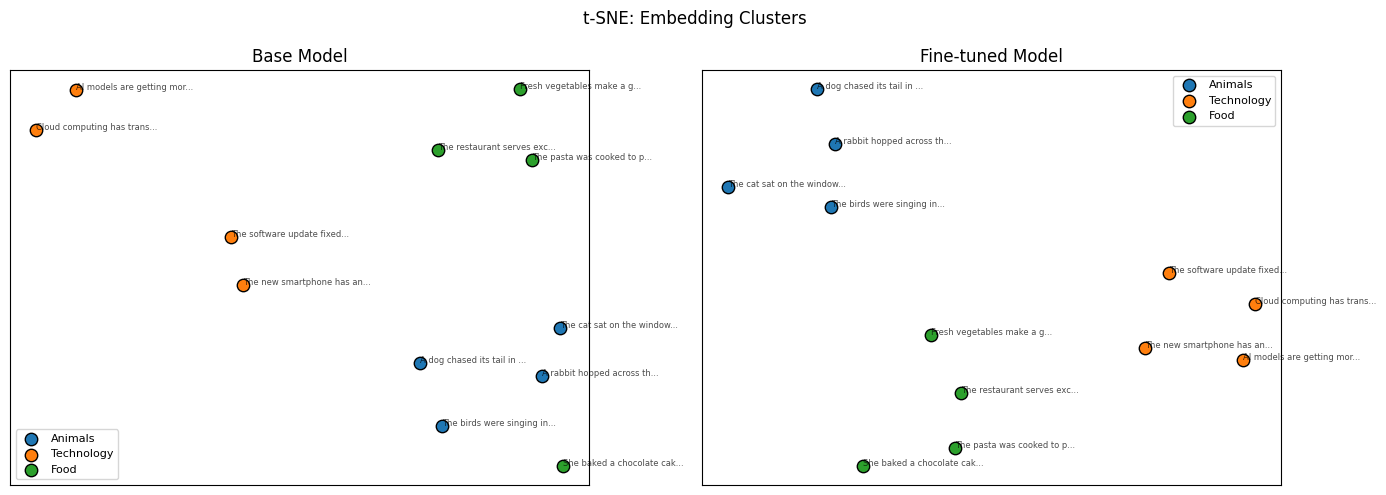

In [4]:
from sklearn.manifold import TSNE

cluster_sentences = [
    # Animals
    "The cat sat on the windowsill.",
    "A dog chased its tail in the yard.",
    "The birds were singing in the morning.",
    "A rabbit hopped across the garden.",
    # Technology
    "The new smartphone has an excellent camera.",
    "AI models are getting more powerful each year.",
    "The software update fixed several bugs.",
    "Cloud computing has transformed the industry.",
    # Food
    "The pasta was cooked to perfection.",
    "She baked a chocolate cake for the party.",
    "The restaurant serves excellent sushi.",
    "Fresh vegetables make a great salad.",
]
cluster_labels = ["Animals"] * 4 + ["Technology"] * 4 + ["Food"] * 4
colors = {"Animals": "tab:blue", "Technology": "tab:orange", "Food": "tab:green"}

ft_embs = np.array(ft_model.encode(cluster_sentences))
base_embs = np.array(base_model.encode(cluster_sentences))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for ax, embs, title in [(ax1, base_embs, "Base Model"), (ax2, ft_embs, "Fine-tuned Model")]:
    tsne = TSNE(n_components=2, random_state=42, perplexity=4)
    coords = tsne.fit_transform(embs)
    for label in colors:
        mask = [l == label for l in cluster_labels]
        ax.scatter(coords[mask, 0], coords[mask, 1], c=colors[label], label=label, s=80, edgecolors="black")
    for i, txt in enumerate(cluster_sentences):
        ax.annotate(txt[:25] + "...", (coords[i, 0], coords[i, 1]), fontsize=6, alpha=0.7)
    ax.set_title(title)
    ax.legend(fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle("t-SNE: Embedding Clusters")
plt.tight_layout()
plt.show()

## 4. Interactive: try your own sentences

Edit the sentences below and re-run to explore.

In [5]:
query = "How do I reset my password?"
candidates = [
    "Click 'Forgot Password' on the login page.",
    "You can change your password in account settings.",
    "Our office is located in downtown Seattle.",
    "The weather forecast calls for rain tomorrow.",
    "Password recovery is available via email verification.",
]

query_emb = ft_model.encode([query])[0]
cand_embs = ft_model.encode(candidates)

sims = [cosine_similarity([query_emb], [e])[0, 0] for e in cand_embs]
ranked = sorted(zip(candidates, sims), key=lambda x: x[1], reverse=True)

print(f"Query: {query}\n")
print(f"{'Rank':<5} {'Similarity':<12} Candidate")
print("-" * 70)
for i, (cand, sim) in enumerate(ranked, 1):
    print(f"{i:<5} {sim:<12.4f} {cand}")

Query: How do I reset my password?

Rank  Similarity   Candidate
----------------------------------------------------------------------
1     0.7158       Click 'Forgot Password' on the login page.
2     0.6369       Password recovery is available via email verification.
3     0.6207       You can change your password in account settings.
4     0.2802       The weather forecast calls for rain tomorrow.
5     0.2524       Our office is located in downtown Seattle.


## 5. Embedding drift: how much did fine-tuning change the representations?

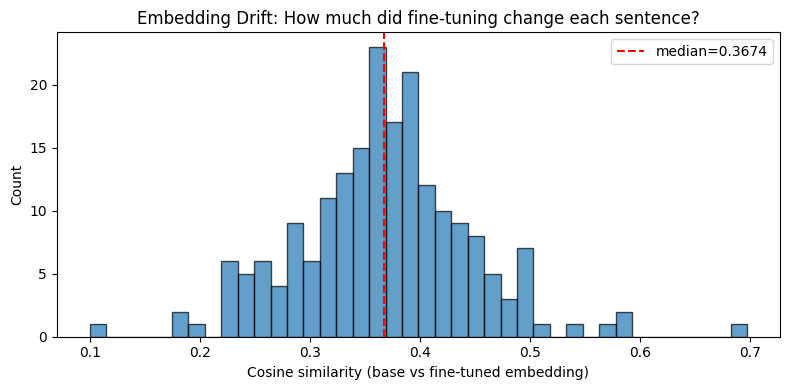

Mean drift (cos sim): 0.3677
Min: 0.0998, Max: 0.6974


In [6]:
from datasets import load_from_disk

ds = load_from_disk("../data/processed/")
sample_texts = ds.shuffle(seed=42).select(range(200))["sent0"]

base_embs = np.array(base_model.encode(sample_texts))
ft_embs = np.array(ft_model.encode(sample_texts))

# Per-sentence cosine similarity between base and fine-tuned
drifts = [cosine_similarity([b], [f])[0, 0] for b, f in zip(base_embs, ft_embs)]

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(drifts, bins=40, edgecolor="black", alpha=0.7)
ax.axvline(np.median(drifts), color="red", linestyle="--", label=f"median={np.median(drifts):.4f}")
ax.set_xlabel("Cosine similarity (base vs fine-tuned embedding)")
ax.set_ylabel("Count")
ax.set_title("Embedding Drift: How much did fine-tuning change each sentence?")
ax.legend()
plt.tight_layout()
plt.show()

print(f"Mean drift (cos sim): {np.mean(drifts):.4f}")
print(f"Min: {np.min(drifts):.4f}, Max: {np.max(drifts):.4f}")